#### Notebook 'Tempo'

In [18]:
# Carga de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from itertools import combinations
from collections import Counter
from pyvis.network import Network
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities


In [19]:
# Crear el DataFrame 'df_aspectos' con los aspectos y las variables asociadas
data_aspectos = {
    'aspecto': ['DROGAS_Y_CORRUPCIÓN'],
    'var_1': ['per603'],
    'var_2': ['per604'],
    'var_3': ['per605'],
    'var_4': ['per104'],
    'var_5': ['per304']
}
df_aspectos = pd.DataFrame(data_aspectos)
display(df_aspectos)
# cargar Analytical_Data
df_AD = pd.read_excel('data/Analytical_Data.xlsx')
display(df_AD.head())

,aspecto,var_1,var_2,var_3,var_4,var_5
0,DROGAS_Y_CORRUPCIÓN,per603,per604,per605,per104,per304


,Dominio,Nombre_Dominio,Variable_per,Detalle_Dominio
0,Domain_1,External Relations,per101,Foreign Special Relationships: Positive
1,Domain_1,External Relations,per102,Foreign Special Relationships: Negative
2,Domain_1,External Relations,per103,Anti-Imperialism
3,Domain_1,External Relations,per104,Military: Positive
4,Domain_1,External Relations,per105,Military: Negative


In [20]:
# Cargar datasets
df = pd.read_excel('./data/MP_Dataset_KMeans_mean.xlsx')  # Dataset principal
print("Datos cargados:")
display(df.head())


Datos cargados:


,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per6013,per6014,per6061,per6071,per6072,per6081,per7051,per7052,per7061,per7062
0,1997,Albania,1.770988,0.00000,0.031388,3.046506,0.015910,0.032313,3.406129,1.114989,...,2.021481,0.0,0.0,0.0,0.0,0.0,0.637892,0.363756,0.0,0.0
1,2001,Albania,2.392570,0.00000,0.000000,2.757403,0.026619,0.023948,3.523162,1.452779,...,0.989546,0.0,0.0,0.0,0.0,0.0,0.897238,0.508457,0.0,0.0
2,1989,Argentina,0.000000,0.00000,4.619213,0.448618,0.828036,0.338070,2.955090,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
3,1995,Argentina,0.061642,0.02014,0.143247,0.882433,0.083005,1.107286,1.996025,1.669947,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
4,1999,Argentina,0.192543,0.00000,0.582363,0.524400,0.017829,0.613450,3.482869,2.262154,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0


#### Paso 3: Definición de Funciones

##### Filtrar y Normalizar

In [21]:
def filtrar_normalizar(df_periodo, variables):
    df_filtered = df_periodo[['countryname', 'agno'] + list(variables)].copy()
    df_filtered.dropna(inplace=True)
    columns_per = variables
    df_filtered['per_sum'] = df_filtered[columns_per].sum(axis=1)
    rows_to_normalize = df_filtered['per_sum'] != 1.0
    df_filtered.loc[rows_to_normalize, columns_per] = df_filtered.loc[rows_to_normalize, columns_per].div(
        df_filtered.loc[rows_to_normalize, 'per_sum'], axis=0
    )
    df_filtered.drop(columns=['per_sum'], inplace=True)
    return df_filtered


In [22]:
def preprocesar_periodo(df, desde, hasta):
    """
    Preprocesa el DataFrame para el período seleccionado.
    Combina registros de países con múltiples elecciones en el período y normaliza las variables.
    
    Parámetros:
    - df: DataFrame principal con datos de programas de gobierno.
    - desde: Año inicial del período.
    - hasta: Año final del período.

    Retorna:
    - df_periodo: DataFrame preprocesado con un registro por país en el período.
    """
    # Filtrar el DataFrame para el período
    df_periodo = df[(df['agno'] >= desde) & (df['agno'] <= hasta)]

    # Identificar países con más de una elección en el período
    duplicated_countries = df_periodo['countryname'].value_counts()
    duplicated_countries = duplicated_countries[duplicated_countries > 1]

    if not duplicated_countries.empty:
        #print("\nPaíses con más de una elección en el período:")
        for country in duplicated_countries.index:
            #print(f"\n{country}:")

            # Filtrar datos del país con duplicados
            country_data = df_periodo[df_periodo['countryname'] == country]

            # Imprimir los registros originales
            #print(f"Registros originales ({len(country_data)}):")
            #display(country_data)

            # Promediar las columnas `per` y conservar el primer año
            per_columns = [col for col in df_periodo.columns if col.startswith('per')]
            averaged_row = country_data[per_columns].mean().to_dict()
            averaged_row['agno'] = country_data['agno'].min()  # Primer año del período
            averaged_row['countryname'] = country

            # Imprimir los valores promedio
            #print("\nValores promediados:")
            for key, value in averaged_row.items():
                if key in per_columns:  # Solo mostrar columnas 'per'
                    print(f"{key}: {value:.4f}")

            # Eliminar los registros originales del dataframe filtrado
            df_periodo = df_periodo[df_periodo['countryname'] != country]

            # Agregar el registro promediado al dataframe
            df_periodo = pd.concat([df_periodo, pd.DataFrame([averaged_row])], ignore_index=True)

    else:
        print("\nNo hay países con más de una elección en el período.")

    # Verificar los resultados finales
    #print("\nDataframe ajustado (un registro por país en el período):")
    #display(df_periodo)

    return df_periodo


In [23]:
def filtrar_y_normalizar(df_periodo, variables):
    """
    Filtra y normaliza las columnas 'per' en un DataFrame para un período específico.
    Elimina registros con valores NaN o donde todas las columnas 'per' seleccionadas son 0.

    Parámetros:
    - df_periodo: DataFrame ya preprocesado para un período (salida de `preprocesar_periodo`).
    - variables: Lista de columnas 'per' relevantes para el aspecto en análisis.

    Retorna:
    - df_filtered: DataFrame filtrado y normalizado.
    """
    # Filtrar el DataFrame para las columnas seleccionadas
    df_filtered = df_periodo[['countryname', 'agno'] + list(variables)].copy()

    # Identificar registros con valores NaN
    registros_nan = df_filtered[df_filtered[variables].isna().any(axis=1)]
    if not registros_nan.empty:
        print("\nRegistros eliminados por contener valores NaN:")
        #display(registros_nan)

    # Eliminar registros con valores NaN
    df_filtered.dropna(inplace=True)

    # Identificar registros con todos los valores en cero
    registros_cero = df_filtered[df_filtered[variables].sum(axis=1) == 0]
    if not registros_cero.empty:
        print("\nRegistros eliminados por tener todas las variables seleccionadas en cero:")
        #display(registros_cero)

    # Eliminar registros con todos los valores en cero
    df_filtered = df_filtered[df_filtered[variables].sum(axis=1) > 0]

    # Normalizar las columnas 'per'
    columns_per = variables
    df_filtered['per_sum'] = df_filtered[columns_per].sum(axis=1)
    rows_to_normalize = df_filtered['per_sum'] != 1.0
    df_filtered.loc[rows_to_normalize, columns_per] = df_filtered.loc[rows_to_normalize, columns_per].div(
        df_filtered.loc[rows_to_normalize, 'per_sum'], axis=0
    )
    df_filtered.drop(columns=['per_sum'], inplace=True)

    # Verificar que las variables 'per' sumen 1
    assert df_filtered[columns_per].sum(axis=1).round(6).eq(1).all(), "Error: las variables 'per' no suman 1."

    return df_filtered


##### PCA y K-MEANS

In [24]:
def ejecutar_y_visualizar_pca_kmeans(df_filtered, variables, aspecto_filtro, desde, hasta):
    """
    Ejecuta PCA y K-MEANS, y visualiza los resultados en 2D y 3D con títulos personalizados.
    
    Parámetros:
    - df_filtered: DataFrame filtrado y normalizado.
    - variables: Lista de variables 'per' a incluir en el análisis.
    - aspecto_filtro: Aspecto analizado (str).
    - desde: Año inicial del período.
    - hasta: Año final del período.
    
    Retorna:
    - df_pca: DataFrame con las componentes principales y los clústeres.
    - pca: Objeto PCA ajustado.
    - kmeans: Objeto K-MEANS ajustado.
    """
    # Paso 1: Ejecutar PCA
    numeric_data = df_filtered[variables]
    pca = PCA(n_components=min(len(variables), 3))  # Usar hasta 3 componentes principales
    pca_components = pca.fit_transform(numeric_data)
    
    # Crear DataFrame con las componentes principales
    df_pca = pd.DataFrame(
        pca_components, 
        columns=[f'PC{i+1}' for i in range(pca.n_components_)],
        index=df_filtered.index
    )
    df_pca = pd.concat([df_filtered[['countryname', 'agno']], df_pca], axis=1)
    
    # Paso 2: Aplicar K-MEANS
    optimal_k = 3  # Por defecto usamos 3 clústeres (puedes ajustar o calcular dinámicamente)
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    df_pca['cluster'] = kmeans.fit_predict(df_pca[[f'PC{i+1}' for i in range(pca.n_components_)]])
    
    # Paso 3: Visualizar clústeres en 2D
    # plt.figure(figsize=(12, 6))
    # for cluster in range(optimal_k):
    #     cluster_data = df_pca[df_pca['cluster'] == cluster]
    #     plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'Cluster {cluster}', alpha=0.7)
    # plt.title(f"Clústeres en 2D (PCA)\nAspecto: {aspecto_filtro} | Período: {desde}-{hasta}")
    # plt.xlabel('PC1')
    # plt.ylabel('PC2')
    # plt.legend()
    # plt.grid(alpha=0.3)
    # plt.tight_layout()
    # plt.show()
    
    return df_pca, pca, kmeans


##### Matriz de coincidencias

In [25]:
def construir_matriz_coincidencias(resultados_temporales):
    coincidencias = Counter()
    for clusters in resultados_temporales.values():
        for cluster in clusters.values():
            for pair in combinations(sorted(cluster), 2):
                coincidencias[pair] += 1

    # Convertir a matriz
    paises = sorted(set([p for pair in coincidencias.keys() for p in pair]))
    coincidence_matrix = pd.DataFrame(0, index=paises, columns=paises)

    for (p1, p2), count in coincidencias.items():
        coincidence_matrix.loc[p1, p2] = count
        coincidence_matrix.loc[p2, p1] = count

    return coincidence_matrix


##### Visualización del grafo

In [26]:
# from pyvis.network import Network
# import networkx as nx
# from networkx.algorithms.community import greedy_modularity_communities

# def grafo_coincidencias(coincidence_matrix):
#     """
#     Crea un grafo interactivo mejorado a partir de la matriz de coincidencias.
    
#     - Ajusta colores de nodos según las comunidades detectadas.
#     - Modifica el grosor de las líneas según el peso de las conexiones.
#     - Ajusta el tamaño de los nodos según su grado.
#     - Añade una leyenda descriptiva al grafo.
#     """
#     # Crear el grafo de NetworkX
#     G = nx.Graph()
#     for i, row in coincidence_matrix.iterrows():
#         for j, value in row.items():
#             if value > 0:  # Solo conexiones con peso mayor a 0
#                 G.add_edge(i, j, weight=value)

#     # Validar que las aristas tengan el atributo 'weight'
#     for u, v, data in G.edges(data=True):
#         if "weight" not in data:
#             data["weight"] = 1  # Asignar un peso por defecto si no existe

#     # Detectar comunidades usando modularidad
#     communities = list(greedy_modularity_communities(G))
#     community_map = {}
#     for community_index, community_nodes in enumerate(communities):
#         for node in community_nodes:
#             community_map[node] = community_index

#     # Crear un grafo interactivo con PyVis
#     net = Network(notebook=True, height="750px", width="100%", cdn_resources="remote")
#     net.from_nx(G)

#     # Ajustar nodos y aristas
#     for node in net.nodes:
#         # Color del nodo según la comunidad
#         community = community_map[node["id"]]
#         node["color"] = f"hsl({community * 360 / len(communities)}, 70%, 70%)"
        
#         # Tamaño del nodo según el grado
#         node["value"] = len(list(G.neighbors(node["id"])))

#     for edge in net.edges:
#         # Grosor de las aristas según el peso
#         weight = G[edge["from"]][edge["to"]].get("weight", 1)  # Usar un peso por defecto si falta
#         edge["value"] = weight

#     # Añadir una leyenda descriptiva al grafo
#     legend_html = """
#     <div style="position: absolute; top: 10px; right: 10px; background-color: white; border: 1px solid black; padding: 10px; z-index: 1000;">
#         <strong>Leyenda:</strong>
#         <ul style="list-style-type: none; padding-left: 0;">
#             <li><strong>Nodos:</strong> Países</li>
#             <li><strong>Tamaño:</strong> Grado del nodo (cantidad de conexiones)</li>
#             <li><strong>Color:</strong> Comunidad detectada</li>
#             <li><strong>Aristas:</strong> Coincidencias entre países</li>
#             <li><strong>Grosor:</strong> Peso de la conexión</li>
#         </ul>
#     </div>
#     """
#     net.html += legend_html

#     # Mostrar el grafo
#     net.show("grafo_coincidencias.html")
#     print("Grafo guardado como 'grafo_coincidencias.html'. Ábrelo para visualizar.")


#### Grafo de Trayectorias temporales

#### Gráfico de coincidencias (con un cierto mínimo)

In [27]:
from pyvis.network import Network
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities

def grafo_coincidencias_filtrado(coincidence_matrix, min_coincidencias=10):
    """
    Crea un grafo interactivo mejorado a partir de la matriz de coincidencias,
    filtrando conexiones con menos de `min_coincidencias` coincidencias.
    
    Parámetros:
    - coincidence_matrix: Matriz de coincidencias entre países.
    - min_coincidencias: Número mínimo de coincidencias para mostrar una conexión.
    """
    # Crear el grafo de NetworkX
    G = nx.Graph()
    for i, row in coincidence_matrix.iterrows():
        for j, value in row.items():
            if value >= min_coincidencias:  # Filtrar por número mínimo de coincidencias
                G.add_edge(i, j, weight=value)  # Añadir peso correctamente

    # Detectar comunidades usando modularidad
    communities = list(greedy_modularity_communities(G))
    community_map = {}
    for community_index, community_nodes in enumerate(communities):
        for node in community_nodes:
            community_map[node] = community_index

    # Crear un grafo interactivo con PyVis
    net = Network(notebook=True, height="750px", width="100%", cdn_resources="remote")
    net.from_nx(G)

    # Configurar físicas para deshabilitarlas
    net.set_options("""
    var options = {
      "physics": {
        "enabled": false
      }
    }
    """)

    # Ajustar nodos y aristas
    for node in net.nodes:
        # Color del nodo según la comunidad
        community = community_map[node["id"]]
        node["color"] = f"hsl({community * 360 / len(communities)}, 70%, 70%)"
        
        # Tamaño del nodo según el grado
        node["value"] = len(list(G.neighbors(node["id"])))

    for edge in net.edges:
        # Grosor de las aristas según el peso
        from_node = edge["from"]
        to_node = edge["to"]
        if G.has_edge(from_node, to_node):
            edge["width"] = G[from_node][to_node].get("weight", 1)  # Usar 1 como valor por defecto

    # Guardar el grafo en un archivo HTML
    output_file = "grafo_coincidencias_filtrado.html"
    net.show(output_file)
    print(f"Grafo guardado como '{output_file}'. Ábrelo para visualizar.")
    
    # Agregar la leyenda directamente al archivo HTML
    legend_html = f"""
    <div style="position: absolute; top: 10px; right: 10px; background-color: white; border: 1px solid black; padding: 10px; z-index: 1000;">
        <strong>Leyenda:</strong>
        <ul style="list-style-type: none; padding-left: 0;">
            <li><strong>Nodos:</strong> Países</li>
            <li><strong>Tamaño:</strong> Grado del nodo (cantidad de conexiones)</li>
            <li><strong>Color:</strong> Comunidad detectada</li>
            <li><strong>Aristas:</strong> Coincidencias entre países</li>
            <li><strong>Grosor:</strong> Peso de la conexión (coincidencias >= {min_coincidencias})</li>
        </ul>
    </div>
    """
    with open(output_file, "r", encoding="utf-8") as file:
        html_content = file.read()
    
    # Insertar la leyenda antes del cierre del body
    html_content = html_content.replace("</body>", legend_html + "\n</body>")
    
    with open(output_file, "w", encoding="utf-8") as file:
        file.write(html_content)

    print("Leyenda añadida al archivo HTML.")


#### Heatmap de coincidencias (con un cierto mínimo)

In [28]:
def heatmap_coincidencias_filtrado(coincidence_matrix, min_coincidencias=10, cmap="coolwarm"):
    """
    Genera un heatmap mostrando solo los países que tienen coincidencias >= min_coincidencias,
    con las celdas que cumplen mostrando el número real de coincidencias y las que no cumplen en blanco.
    
    Parámetros:
    - coincidence_matrix: Matriz de coincidencias entre países.
    - min_coincidencias: Número mínimo de coincidencias para considerar un enlace.
    - cmap: Paleta de colores para el heatmap.
    """
    # Crear una copia de la matriz para no modificar el original
    filtered_matrix = coincidence_matrix.copy()
    
    # Filtrar países que cumplen el umbral en filas o columnas
    relevant_countries = (filtered_matrix >= min_coincidencias).sum(axis=1) > 0
    filtered_matrix = filtered_matrix.loc[relevant_countries, relevant_countries]
    
    # Crear una máscara para ocultar valores por debajo del umbral
    mask = filtered_matrix < min_coincidencias
    
    # Verificar si quedan datos para graficar
    if filtered_matrix.empty:
        print(f"No hay países con coincidencias >= {min_coincidencias}.")
        return
    
    # Crear el heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        filtered_matrix,
        annot=filtered_matrix.where(~mask).round(0),  # Mostrar valores enteros redondeados
        fmt="g",  # Usar formato general (float/int)
        cmap=cmap,
        linewidths=0.5,  # Añadir líneas de la grilla
        linecolor="gray",
        cbar_kws={"label": "Número de Coincidencias"},
        mask=mask  # Aplicar la máscara
    )
    plt.title(f"Heatmap de Coincidencias Filtrado (≥ {min_coincidencias})", fontsize=14)
    plt.xlabel("País")
    plt.ylabel("País")
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()


#### Ejecución para un período

In [ ]:
# Definir el período específico
desde = 2019
hasta = 2022

# Definir las variables asociadas al aspecto de análisis
aspecto_filtro = 'DROGAS_Y_CORRUPCIÓN'
variables = df_aspectos[df_aspectos['aspecto'] == aspecto_filtro][['var_1', 'var_2', 'var_3', 'var_4', 'var_5']].dropna().values.flatten()

# Preprocesar y normalizar los datos del período seleccionado
df_periodo = preprocesar_periodo(df, desde, hasta)
df_filtered = filtrar_y_normalizar(df_periodo, variables)

# Verificar el resultado del DataFrame filtrado
print("\nDataFrame filtrado y normalizado:")
print(df_filtered.info())
display(df_filtered.head())

# Ejecutar y visualizar PCA y K-MEANS
df_pca, pca, kmeans = ejecutar_y_visualizar_pca_kmeans(df_filtered, variables, aspecto_filtro, desde, hasta)



#### Ejecución para Múltiples Períodos


Procesando período: 1949-1951
per101: 2.1474
per102: 0.0000
per103: 0.0000
per104: 4.9943
per105: 0.6320
per106: 0.8173
per107: 1.6590
per108: 0.0000
per109: 0.0614
per110: 0.0000
per201: 1.7767
per202: 0.9856
per203: 2.0346
per204: 0.0000
per301: 0.6445
per302: 0.1459
per303: 3.9862
per304: 0.0000
per305: 5.0049
per401: 4.0828
per402: 1.2052
per403: 1.9520
per404: 3.2042
per405: 0.0000
per406: 0.3774
per407: 0.0829
per408: 7.3901
per409: 0.0000
per410: 2.9427
per411: 2.3328
per412: 0.0000
per413: 0.1911
per414: 6.9560
per415: 0.0000
per416: 0.0000
per501: 0.0000
per502: 1.9677
per503: 0.0717
per504: 6.2054
per505: 0.4563
per506: 0.4265
per507: 0.0000
per601: 0.0000
per602: 0.0000
per603: 1.5246
per604: 0.0000
per605: 0.1459
per606: 6.4896
per607: 0.0000
per608: 0.0000
per701: 10.0045
per702: 0.9515
per703: 9.5408
per704: 0.5288
per705: 0.0000
per706: 3.8357
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



Procesando período: 1955-1957

No hay países con más de una elección en el período.

Registros eliminados por tener todas las variables seleccionadas en cero:

Procesando período: 1958-1960
per101: 0.0000
per102: 0.1926
per103: 0.0000
per104: 0.5380
per105: 0.5684
per106: 1.9586
per107: 1.0020
per108: 0.3747
per109: 0.1196
per110: 0.0000
per201: 1.3564
per202: 0.4778
per203: 0.0817
per204: 0.0409
per301: 2.4830
per302: 0.0000
per303: 0.8103
per304: 0.0000
per305: 0.0000
per401: 2.8665
per402: 5.3536
per403: 1.3461
per404: 0.1189
per405: 0.0000
per406: 0.5214
per407: 0.2334
per408: 1.2524
per409: 0.4382
per410: 1.0118
per411: 1.7636
per412: 0.3731
per413: 0.0269
per414: 9.4882
per415: 0.0000
per416: 0.0000
per501: 0.0320
per502: 0.5464
per503: 2.2538
per504: 21.3379
per505: 1.9741
per506: 6.2660
per507: 0.1464
per601: 0.0000
per602: 0.0000
per603: 1.7193
per604: 0.0000
per605: 0.4652
per606: 0.2312
per607: 1.0414
per608: 0.0000
per701: 0.0693
per702: 0.0000
per703: 3.5806
per704: 0.000

/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



Procesando período: 1961-1963
per101: 4.1161
per102: 0.0150
per103: 0.0489
per104: 4.2341
per105: 0.0000
per106: 0.0000
per107: 3.1279
per108: 0.0000
per109: 0.4960
per110: 0.0000
per201: 0.1003
per202: 2.7112
per203: 0.2236
per204: 0.0000
per301: 0.9995
per302: 0.0000
per303: 0.7673
per304: 0.0000
per305: 6.4279
per401: 2.6064
per402: 10.2760
per403: 0.8124
per404: 1.8560
per405: 0.0000
per406: 2.0115
per407: 0.2583
per408: 2.4890
per409: 0.0000
per410: 2.8200
per411: 4.6613
per412: 0.0000
per413: 0.0000
per414: 5.8662
per415: 0.0000
per416: 0.0000
per501: 0.3361
per502: 0.0000
per503: 0.0150
per504: 4.1312
per505: 0.0000
per506: 6.2518
per507: 0.0000
per601: 0.2723
per602: 0.0000
per603: 0.0489
per604: 0.0000
per605: 0.0000
per606: 3.4445
per607: 0.0000
per608: 0.0000
per701: 10.4757
per702: 0.0000
per703: 12.7319
per704: 0.0000
per705: 0.0000
per706: 1.1687
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.000

/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



Procesando período: 1964-1966
per101: 1.4395
per102: 0.3878
per103: 0.5821
per104: 1.3394
per105: 0.7189
per106: 2.0225
per107: 4.4525
per108: 1.3977
per109: 0.4939
per110: 0.0976
per201: 1.3969
per202: 1.0905
per203: 0.5181
per204: 0.1464
per301: 2.4309
per302: 0.3202
per303: 2.5883
per304: 0.1423
per305: 1.0576
per401: 1.6040
per402: 1.2262
per403: 1.1416
per404: 1.2122
per405: 0.0000
per406: 0.3319
per407: 0.3792
per408: 3.1818
per409: 0.1415
per410: 1.5568
per411: 4.1373
per412: 0.8207
per413: 0.8252
per414: 2.1402
per415: 0.0000
per416: 0.0000
per501: 1.9250
per502: 2.2381
per503: 3.5409
per504: 7.6122
per505: 0.5126
per506: 3.4874
per507: 0.3290
per601: 1.1895
per602: 0.1952
per603: 0.2377
per604: 0.0000
per605: 1.5324
per606: 1.1535
per607: 0.0425
per608: 0.0000
per701: 1.2695
per702: 0.7556
per703: 2.2299
per704: 0.9941
per705: 0.4990
per706: 1.9834
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000
p

/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



Procesando período: 1970-1972
per101: 0.5051
per102: 0.6257
per103: 0.4223
per104: 1.3395
per105: 0.5275
per106: 2.0263
per107: 4.8391
per108: 1.1464
per109: 0.0050
per110: 0.0187
per201: 3.4606
per202: 8.6415
per203: 1.0740
per204: 0.0072
per301: 0.8525
per302: 0.1688
per303: 3.8881
per304: 0.0000
per305: 0.1809
per401: 1.9651
per402: 1.9151
per403: 2.2505
per404: 1.7451
per405: 0.0917
per406: 0.0433
per407: 0.0541
per408: 1.3290
per409: 0.7986
per410: 0.5486
per411: 4.0336
per412: 1.5625
per413: 0.3478
per414: 2.6845
per415: 0.0000
per416: 0.0000
per501: 5.8858
per502: 4.1313
per503: 6.2297
per504: 10.1401
per505: 0.2452
per506: 5.6946
per507: 0.1850
per601: 0.0363
per602: 0.0040
per603: 1.3136
per604: 1.3006
per605: 1.3284
per606: 0.3727
per607: 0.6202
per608: 0.0431
per701: 0.6499
per702: 0.0000
per703: 0.7583
per704: 1.1380
per705: 0.5305
per706: 4.6422
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



Procesando período: 1976-1978
per101: 0.2666
per102: 0.0000
per103: 1.0093
per104: 0.3351
per105: 0.9449
per106: 0.1423
per107: 0.7398
per108: 3.9329
per109: 0.6788
per110: 0.3174
per201: 2.9386
per202: 5.0208
per203: 0.4787
per204: 0.3870
per301: 4.8880
per302: 0.0215
per303: 3.1627
per304: 0.3845
per305: 0.8823
per401: 3.1863
per402: 2.4303
per403: 2.0521
per404: 1.6454
per405: 0.0000
per406: 0.0429
per407: 0.0730
per408: 4.8469
per409: 0.3776
per410: 0.6337
per411: 4.6877
per412: 0.8864
per413: 0.6433
per414: 1.8161
per415: 0.0000
per416: 0.0043
per501: 3.2892
per502: 5.5790
per503: 4.1566
per504: 3.8341
per505: 0.6107
per506: 1.5562
per507: 0.0316
per601: 0.3937
per602: 0.2357
per603: 1.0490
per604: 0.2447
per605: 0.2870
per606: 0.9030
per607: 1.4855
per608: 0.4589
per701: 0.9552
per702: 0.0000
per703: 1.4542
per704: 3.4094
per705: 2.1842
per706: 10.8459
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



Procesando período: 1982-1984
per101: 0.6241
per102: 0.1402
per103: 0.0000
per104: 3.8285
per105: 0.0000
per106: 1.6828
per107: 0.8471
per108: 0.0000
per109: 0.0000
per110: 0.0000
per201: 0.8107
per202: 0.7265
per203: 1.7381
per204: 0.0000
per301: 0.1361
per302: 0.0000
per303: 2.5377
per304: 0.0798
per305: 1.0279
per401: 3.6150
per402: 5.8324
per403: 1.1164
per404: 1.7552
per405: 0.0557
per406: 0.3872
per407: 0.6056
per408: 3.6310
per409: 0.0000
per410: 6.1008
per411: 4.5932
per412: 0.2393
per413: 0.4254
per414: 3.2948
per415: 0.0000
per416: 0.0000
per501: 2.0388
per502: 2.9376
per503: 2.7662
per504: 4.0878
per505: 0.3901
per506: 4.3959
per507: 0.0000
per601: 4.1855
per602: 0.0000
per603: 2.2413
per604: 0.0000
per605: 1.3137
per606: 5.0290
per607: 0.5374
per608: 0.0372
per701: 0.3061
per702: 2.4002
per703: 3.5474
per704: 0.2402
per705: 0.5332
per706: 8.7510
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000
p

/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



Procesando período: 1988-1990
per101: 1.4629
per102: 0.3079
per103: 0.0000
per104: 6.4252
per105: 1.1780
per106: 0.3020
per107: 2.1517
per108: 3.9203
per109: 0.8976
per110: 0.8554
per201: 0.8614
per202: 2.3793
per203: 0.0383
per204: 0.0159
per301: 1.3570
per302: 0.1967
per303: 1.7576
per304: 0.1254
per305: 0.5727
per401: 1.4683
per402: 4.3018
per403: 0.6458
per404: 0.3127
per405: 0.9686
per406: 0.0000
per407: 0.0658
per408: 3.3659
per409: 0.0195
per410: 0.9071
per411: 2.1874
per412: 1.0050
per413: 0.0268
per414: 0.5495
per415: 0.0195
per416: 0.1979
per501: 4.9930
per502: 0.4180
per503: 3.3209
per504: 5.4938
per505: 1.0866
per506: 3.4957
per507: 0.0435
per601: 0.1557
per602: 0.0537
per603: 1.6161
per604: 0.0000
per605: 2.0639
per606: 2.1533
per607: 0.1162
per608: 0.1062
per701: 7.6167
per702: 0.2547
per703: 0.6099
per704: 0.2217
per705: 0.0000
per706: 4.6578
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000
p

/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



Procesando período: 1994-1996
per101: 0.0000
per102: 0.0000
per103: 0.0000
per104: 0.7975
per105: 0.0209
per106: 0.6113
per107: 2.6289
per108: 1.5122
per109: 0.3671
per110: 0.3636
per201: 4.9681
per202: 2.2607
per203: 1.1890
per204: 0.0000
per301: 0.6372
per302: 0.0256
per303: 8.0418
per304: 4.1051
per305: 10.3292
per401: 6.2473
per402: 3.5749
per403: 0.8556
per404: 0.0640
per405: 0.0421
per406: 0.0549
per407: 0.2746
per408: 3.8976
per409: 0.0823
per410: 2.8806
per411: 4.3500
per412: 0.0144
per413: 0.0586
per414: 3.4086
per415: 0.0000
per416: 0.0250
per501: 5.1389
per502: 1.0048
per503: 6.9750
per504: 3.5271
per505: 1.2768
per506: 3.1195
per507: 0.0000
per601: 1.6126
per602: 0.1256
per603: 1.7638
per604: 0.2364
per605: 3.3267
per606: 1.9865
per607: 0.2342
per608: 0.0723
per701: 1.0026
per702: 0.0000
per703: 0.9077
per704: 0.0707
per705: 1.5341
per706: 1.1712
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



Procesando período: 2001-2003
per101: 0.2141
per102: 0.0012
per103: 0.0256
per104: 0.6016
per105: 0.1814
per106: 0.4436
per107: 2.5564
per108: 3.0136
per109: 0.0736
per110: 0.1038
per201: 3.1813
per202: 2.6210
per203: 0.1641
per204: 0.0000
per301: 1.6293
per302: 0.0195
per303: 6.4482
per304: 0.1588
per305: 4.3908
per401: 1.6829
per402: 2.9197
per403: 2.1480
per404: 0.0116
per405: 0.0102
per406: 0.0274
per407: 0.5137
per408: 2.3471
per409: 0.0678
per410: 0.4571
per411: 7.0439
per412: 0.0008
per413: 0.0106
per414: 1.6215
per415: 0.0000
per416: 0.5100
per501: 4.2960
per502: 2.2499
per503: 2.6665
per504: 7.3207
per505: 1.0397
per506: 6.7618
per507: 0.0000
per601: 0.7347
per602: 0.0459
per603: 1.5492
per604: 0.1260
per605: 8.2915
per606: 2.5771
per607: 0.2267
per608: 0.8037
per701: 2.2215
per702: 0.0453
per703: 1.4733
per704: 0.4911
per705: 2.1375
per706: 3.1426
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000
p

/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



Procesando período: 2007-2009
per101: 0.0000
per102: 0.0000
per103: 0.0000
per104: 0.5550
per105: 0.5527
per106: 0.1306
per107: 1.9151
per108: 2.7494
per109: 0.3691
per110: 0.5664
per201: 0.9198
per202: 5.0082
per203: 1.1869
per204: 0.0000
per301: 0.5695
per302: 0.0000
per303: 2.8718
per304: 0.8161
per305: 2.3006
per401: 2.2698
per402: 5.4269
per403: 1.2681
per404: 0.6707
per405: 0.2180
per406: 0.0000
per407: 0.3011
per408: 7.8831
per409: 0.7443
per410: 9.3636
per411: 4.2492
per412: 0.1671
per413: 0.8050
per414: 2.7635
per415: 0.0000
per416: 0.9750
per501: 4.7535
per502: 1.3687
per503: 9.9766
per504: 9.2629
per505: 0.2508
per506: 3.8975
per507: 0.1178
per601: 1.5697
per602: 0.0000
per603: 0.4612
per604: 0.0000
per605: 2.4831
per606: 1.9827
per607: 0.4351
per608: 0.1652
per701: 1.3104
per702: 0.0000
per703: 1.7731
per704: 0.1549
per705: 0.8640
per706: 1.4107
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000
p

/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



Procesando período: 2013-2015
per101: 0.0000
per102: 0.0000
per103: 2.8846
per104: 0.7350
per105: 0.0000
per106: 0.1645
per107: 2.0415
per108: 2.1641
per109: 0.0000
per110: 0.0000
per201: 3.9959
per202: 8.6166
per203: 1.0746
per204: 0.0000
per301: 1.3788
per302: 0.0000
per303: 1.6657
per304: 2.9319
per305: 7.2680
per401: 0.2387
per402: 2.2952
per403: 1.1036
per404: 0.4060
per405: 0.0961
per406: 0.3291
per407: 0.2387
per408: 0.5017
per409: 1.1865
per410: 1.8208
per411: 6.3486
per412: 0.5961
per413: 0.9872
per414: 2.3081
per415: 0.0000
per416: 1.0422
per501: 0.4619
per502: 0.6390
per503: 5.5513
per504: 10.5389
per505: 0.1069
per506: 6.7678
per507: 0.0357
per601: 2.0754
per602: 0.0000
per603: 0.2138
per604: 0.0000
per605: 4.7465
per606: 1.8899
per607: 0.2397
per608: 0.0000
per701: 4.9360
per702: 0.0000
per703: 1.7338
per704: 0.0000
per705: 1.7879
per706: 1.7469
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



Procesando período: 2019-2022
per101: 0.7095
per102: 0.0162
per103: 0.0742
per104: 4.0985
per105: 0.1801
per106: 0.0680
per107: 0.9116
per108: 0.0000
per109: 0.0159
per110: 0.0027
per201: 0.8789
per202: 0.9557
per203: 0.0073
per204: 0.0320
per301: 0.7172
per302: 0.0251
per303: 0.7920
per304: 1.7457
per305: 2.0283
per401: 0.7749
per402: 4.4410
per403: 6.4476
per404: 0.2208
per405: 0.2484
per406: 0.2643
per407: 0.1670
per408: 0.0834
per409: 1.3267
per410: 3.2331
per411: 11.0310
per412: 0.5768
per413: 0.3024
per414: 0.3670
per415: 0.0000
per416: 3.1695
per501: 5.9203
per502: 1.6639
per503: 5.8581
per504: 12.9984
per505: 0.0419
per506: 2.5120
per507: 0.0000
per601: 0.9467
per602: 0.7725
per603: 0.2139
per604: 0.0719
per605: 3.7608
per606: 0.4210
per607: 3.4459
per608: 0.0133
per701: 5.6262
per702: 0.2350
per703: 8.3330
per704: 0.0550
per705: 0.0541
per706: 0.8946
per1011: 0.0000
per1012: 0.0000
per1013: 0.0000
per1014: 0.0000
per1015: 0.0000
per1016: 0.0000
per1021: 0.0000
per1022: 0.0000

/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


grafo_coincidencias_filtrado.html
Grafo guardado como 'grafo_coincidencias_filtrado.html'. Ábrelo para visualizar.
Leyenda añadida al archivo HTML.


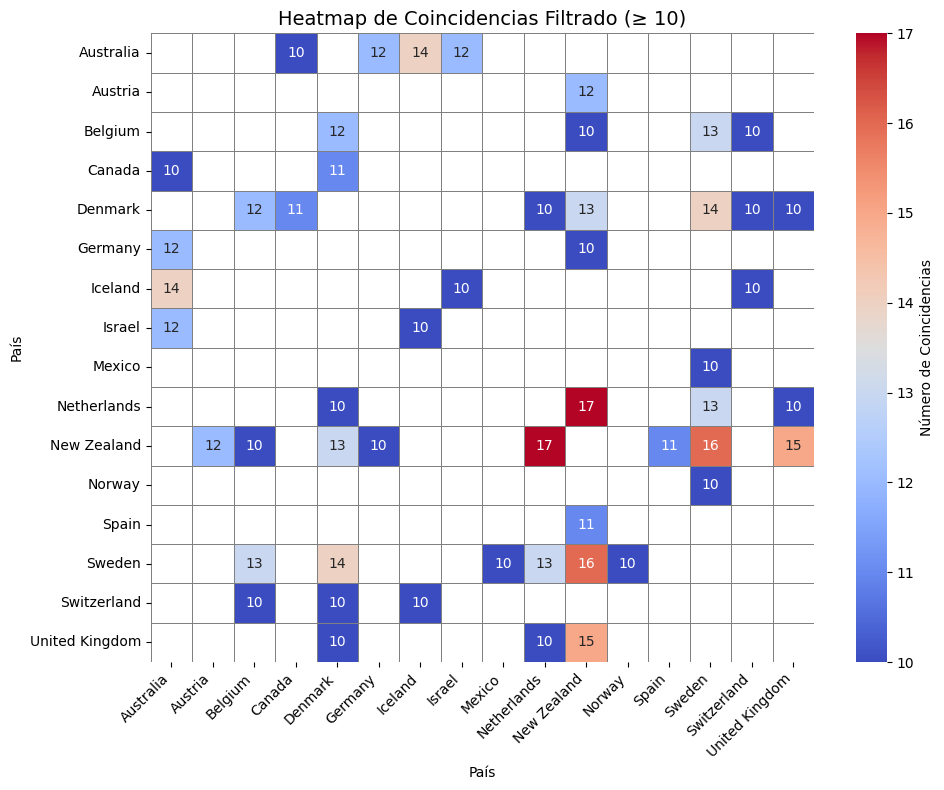

In [29]:
# Definir períodos múltiples para el análisis
periodos = [(1949, 1951),(1952, 1954),(1955, 1957),(1958, 1960),(1961, 1963),(1964, 1966), (1967, 1969), (1970, 1972), (1973, 1975), (1976, 1978), (1979, 1981), (1982, 1984), (1985, 1987), (1988, 1990), (1991, 1993), (1994, 1996), (1997, 2000), (2001, 2003), (2004, 2006), (2007, 2009), (2010, 2012), (2013, 2015), (2016, 2018), (2019, 2022)]
aspecto_filtro = 'DROGAS_Y_CORRUPCIÓN'
variables = df_aspectos[df_aspectos['aspecto'] == aspecto_filtro][['var_1', 'var_2', 'var_3', 'var_4', 'var_5']].dropna().values.flatten()

# Diccionario para almacenar resultados por período
resultados_temporales = {}

for desde, hasta in periodos:
    print(f"\nProcesando período: {desde}-{hasta}")
    
    # Preprocesar y normalizar datos
    df_periodo = preprocesar_periodo(df, desde, hasta)
    df_filtered = filtrar_y_normalizar(df_periodo, variables)
    
    # Ejecutar PCA y K-MEANS
    df_pca, pca, kmeans = ejecutar_y_visualizar_pca_kmeans(df_filtered, variables, aspecto_filtro, desde, hasta)
    
    # Almacenar los países en cada clúster
    clusters = {}
    for cluster in df_pca['cluster'].unique():
        clusters[cluster] = df_pca[df_pca['cluster'] == cluster]['countryname'].unique()
    resultados_temporales[f"{desde}-{hasta}"] = clusters

# Construir y visualizar la matriz de coincidencias
coincidence_matrix = construir_matriz_coincidencias(resultados_temporales)
#grafo_coincidencias(coincidence_matrix)

#paises_seleccionados = ["Armenia", "Finland", "United States", "Australia", "Georgia"]
#paises_seleccionados = ["Armenia", "United States"]
#graficar_trayectorias_seleccion(resultados_temporales, paises_seleccionados)
grafo_coincidencias_filtrado(coincidence_matrix, min_coincidencias=10)

# Ejecutar heatmap filtrando según un umbral
heatmap_coincidencias_filtrado(coincidence_matrix, min_coincidencias=10, cmap="coolwarm")

In [ ]:
coincidence_matrix